In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask
import ingest_tif_stack as ingest

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas_resolution = 50

rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, atlas_resolution)
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

In [105]:
sitk.WriteImage(atlas, './atlas/ara_atlas.img')

In [9]:
no_ant_img = ndreg.download_image(rmt, 'missing_data_registration', 'missing_ant_insula_to_whole_atas', 'raw')
half_img = ndreg.download_image(rmt, 'missing_data_registration', 'missing_half_insula_to_whole_atlas', 'raw')
full_img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
img_width, img_height, img_depth = full_img.GetSize()

# Pad data

In [7]:
def pad_img_with_range(img, depth_range, height_range, width_range, return_mask=True):
    ''' User inputs the known padding parameters '''
    img_width, img_height, img_depth = img.GetSize()
    padded_img_width, padded_img_height, padded_img_depth = img_width+sum(width_range), img_height+sum(height_range), img_depth+sum(depth_range)
    padded_array = np.zeros((padded_img_depth, padded_img_height, padded_img_width))

    
    padded_array[depth_range[0]:(padded_img_depth-depth_range[1]), \
               height_range[0]:(padded_img_height-height_range[1]), \
               width_range[0]:(padded_img_width-width_range[1])] = sitk.GetArrayFromImage(img)
    padded_img = sitk.GetImageFromArray(padded_array)
    padded_img.SetSpacing(img.GetSpacing())
    
    if return_mask:
        padded_mask = np.zeros((padded_img_depth, padded_img_height, padded_img_width), dtype=np.uint16)
        padded_mask[depth_range[0]:(padded_img_depth-depth_range[1]), \
               height_range[0]:(padded_img_height-height_range[1]), \
               width_range[0]:(padded_img_width-width_range[1])] = 1
        padded_mask = sitk.GetImageFromArray(padded_mask)
        padded_mask.SetSpacing(img.GetSpacing())
        return padded_img, padded_mask
    return padded_img


In [10]:
no_ant_img_width, no_ant_img_height, no_ant_img_depth = no_ant_img.GetSize()
padded_range_no_ant_img, padded_range_no_ant_mask = pad_img_with_range(no_ant_img, (0,0), (img_height-no_ant_img_height,0), (0, 0))

half_img_width, half_img_height, half_img_depth = half_img.GetSize()
padded_range_half_img, padded_range_half_mask = pad_img_with_range(half_img, (0,0), (0, 0), (img_width - half_img_width,0))


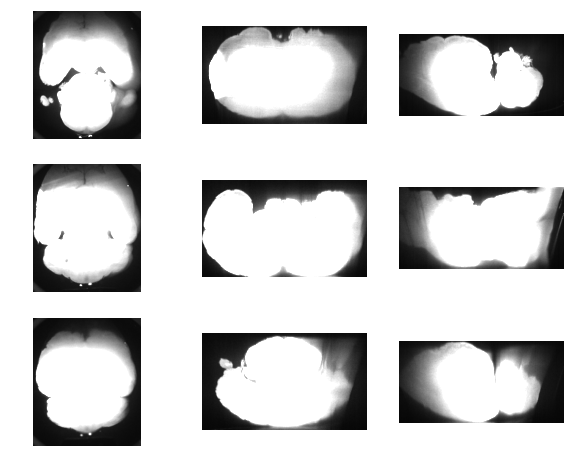

In [77]:
ndreg.imgShow(full_img, vmax=2500)

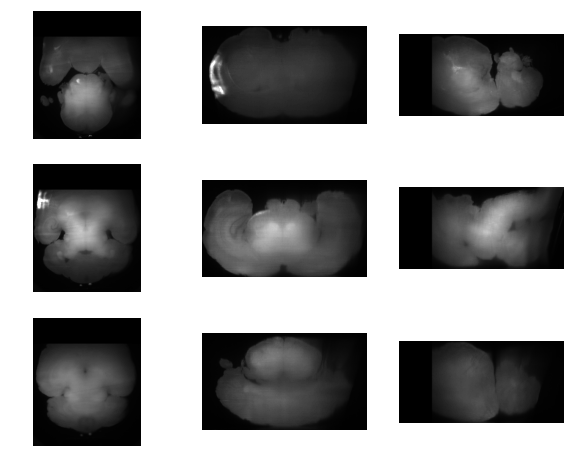

In [14]:
ndreg.imgShow(padded_range_no_ant_img, vmax=2500)

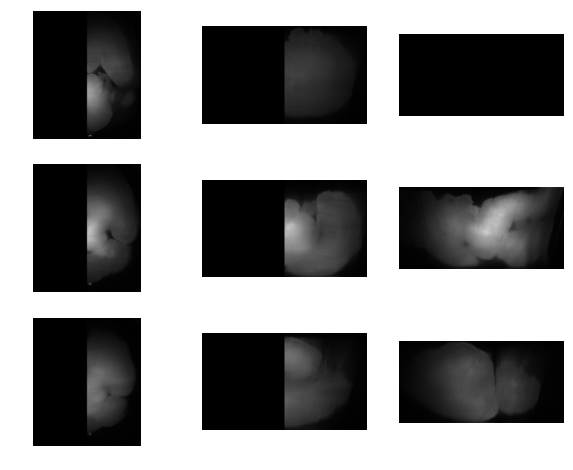

In [15]:
ndreg.imgShow(padded_range_half_img, vmax=2500)

# Registration

In [31]:
mm_to_um = 1000.0
resolution_atlas = 50
orientation_atlas = 'pir'
orientation_image = 'lps'

# img = padded_range_half_img
# mask = padded_range_half_mask
img = padded_range_no_ant_img
mask = padded_range_no_ant_mask

img = ndreg.imgResample(img, [resolution_atlas/mm_to_um]*3)

In [32]:
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(preprocessor.create_mask(img, use_triangle=True), mask_dilation_radius)
img_bc, bias = preprocessor.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask,
                                         num_control_pts=[5,5,5],
                                         niters=[50, 50, 50, 50])

In [33]:
img_bc = ndreg.imgReorient(img_bc, orientation_image, orientation_atlas)
mask = ndreg.imgReorient(mask, orientation_image, orientation_atlas)

atlas_n = sitk.Normalize(atlas)
img_bc_n = sitk.Normalize(img_bc)

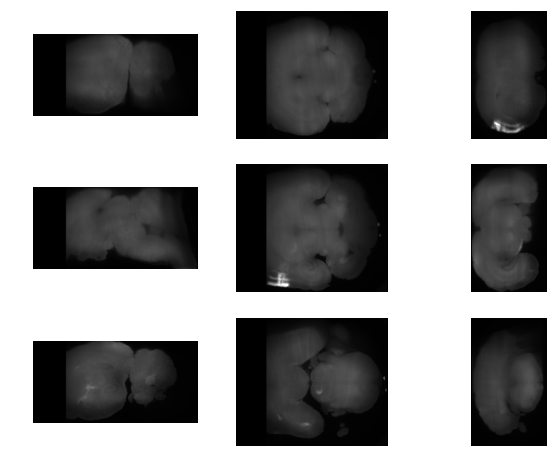

In [34]:
ndreg.imgShow(img_bc, vmax=2500)

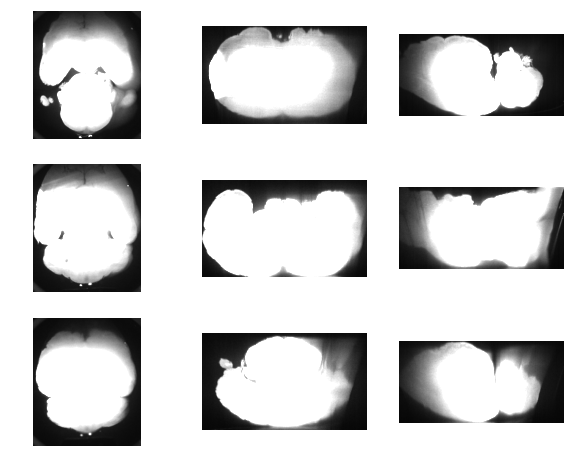

In [86]:
ndreg.imgShow(full_img, vmax=2500)

In [82]:
final_transform = register_rigid(atlas_n, 
                                    sitk.Normalize(full_img),
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [83]:
atlas_rigid = registerer.resample(atlas, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


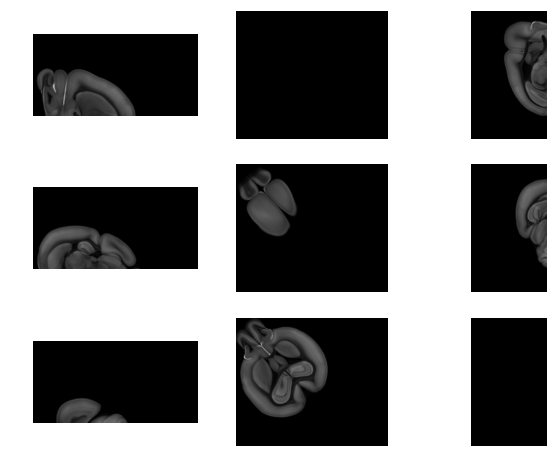

In [84]:
ndreg.imgShow(atlas_rigid)

In [102]:
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)

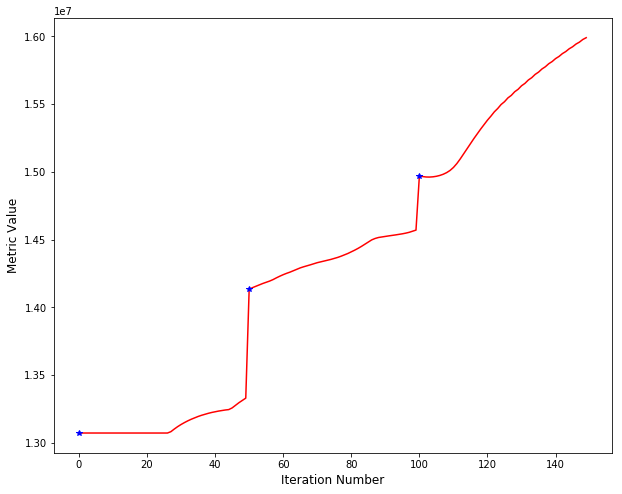

In [104]:
final_transform = register_rigid(atlas_n,
                                    sitk.Normalize(full_img),
                                    fixed_mask=mask,
                                    learning_rate=1e-2,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [91]:
atlas_rigid = registerer.resample(atlas, final_transform.GetInverse(), full_img, default_value=ndreg.imgPercentile(atlas,0.01))


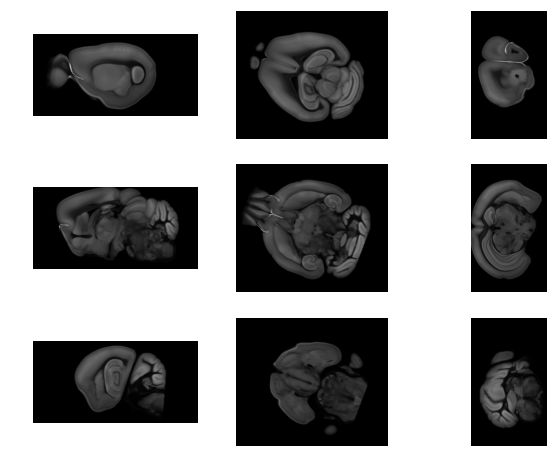

In [92]:
ndreg.imgShow(atlas_rigid)

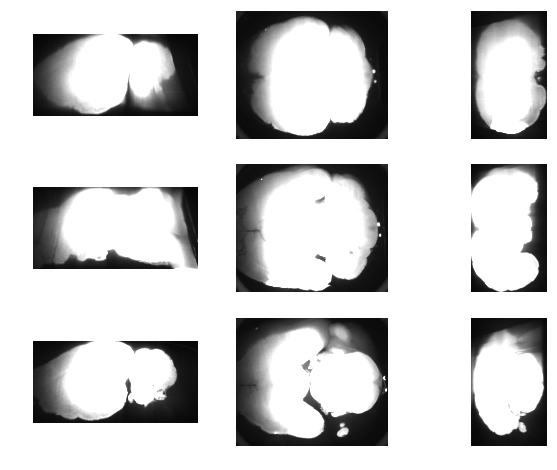

In [103]:
ndreg.imgShow(full_img, vmax=2500)

In [38]:
# whiten the images
whiten_kernel = [5,5,5]
atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_rigid, whiten_kernel, alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, whiten_kernel, alpha=0.25, beta=0.25)

In [39]:
# lddmm code
e = 5e-3
s = 0.1
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	176094, 1411.79, 0, 174683 (96.8662%), 5.500000e-03
1.	172868, 1689.49, 0, 171178 (94.923%), 6.050000e-03
2.	172268, 1895.05, 0, 170373 (94.4763%), 3.327500e-03
3.	171445, 2169.71, 0, 169276 (93.8679%), 3.660250e-03
4.	170688, 2656.85, 0, 168031 (93.1779%), 4.026275e-03
5.	167374, 3360.56, 0, 164013 (90.9497%), 4.428903e-03
6.	167364, 3379.11, 0, 163985 (90.9341%), 1.522435e-04
E = 167364 (90.9341%)
Length = 93.3921
Time = 35.0496s (0.58416m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	149283, 102.846, 0, 149180 (96.2905%), 5.500000e-03
1.	146107, 151.699, 0, 145955 (94.2093%), 6.050000e-03
2.	145872, 222.101, 0, 145650 (94.0121%), 6.655000e-03
3.	144494, 366.284, 0, 144128 (93.0296%), 7.320500e-03
4.	142011, 438.084, 0, 141573 (91.3807%), 4.026275e-03
5.	139898, 547.238, 0, 139351 (89.9464%), 4.428903e-03
6.	138477, 620.

Length = 38.2232
Time = 2628.92s (43.8153m)


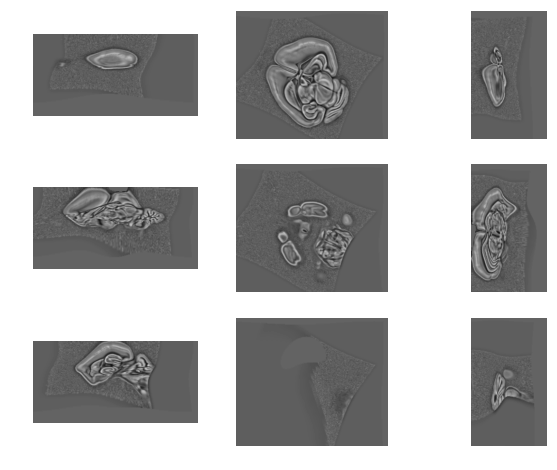

In [40]:
ndreg.imgShow(atlas_lddmm)

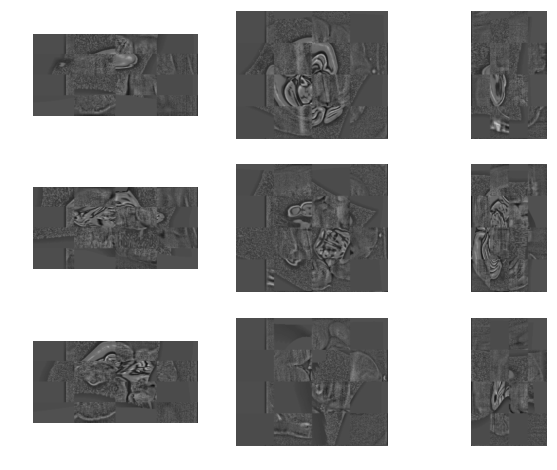

In [42]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm, img_bc_w))

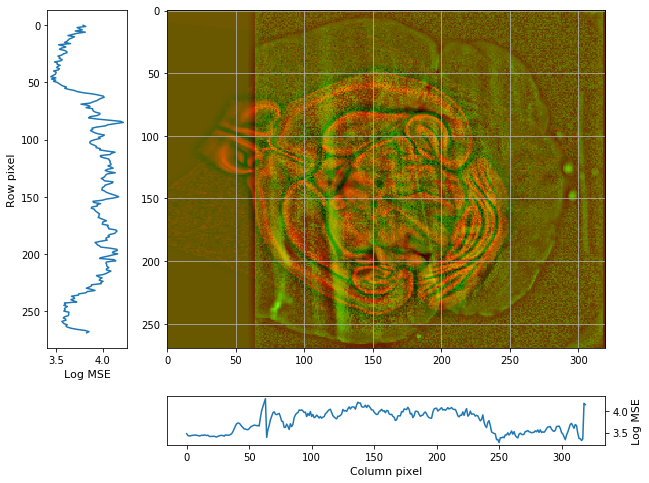

In [67]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[:,50,:], color_blend=True)


# No whitening

In [68]:
# lddmm code
e = 5e-3
s = 0.1
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_rigid), 
                                                          target_img=sitk.Normalize(img_bc),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	54233, 26.2973, 0, 54206.8 (94.8494%), 5.500000e-03
1.	52369, 71.0839, 0, 52297.9 (91.5093%), 6.050000e-03
2.	51337.3, 140.839, 0, 51196.5 (89.5821%), 6.655000e-03
3.	50437.7, 248.201, 0, 50189.4 (87.8201%), 7.320500e-03
4.	49947.7, 395.729, 0, 49552 (86.7047%), 8.052550e-03
5.	49911.9, 453.897, 0, 49458 (86.5401%), 4.428903e-03
6.	49436, 527.205, 0, 48908.7 (85.5791%), 4.871793e-03
7.	48639.2, 622.154, 0, 48017 (84.0188%), 5.358972e-03
8.	47871.9, 744.263, 0, 47127.6 (82.4626%), 5.894869e-03
9.	47696.8, 886.622, 0, 46810.1 (81.907%), 6.484356e-03
10.	47372.3, 1041.27, 0, 46331 (81.0686%), 7.132792e-03
11.	46925.9, 1230.51, 0, 45695.4 (79.9565%), 7.846071e-03
E = 46925.9 (79.9565%)
Length = 31.9393
Time = 74.2471s (1.23745m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	50797.8, 23.3599, 0, 50774.4 (94.7282%), 5.500000e-03


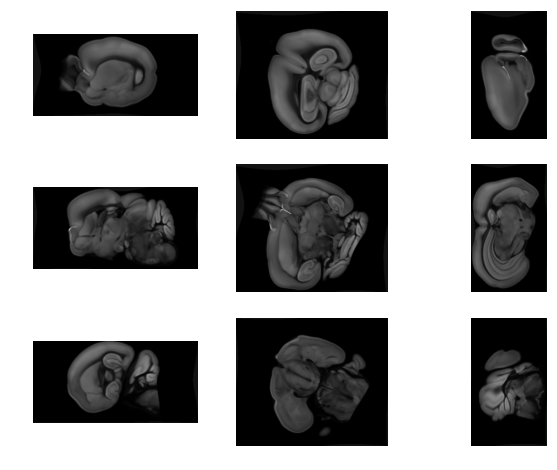

In [69]:
ndreg.imgShow(atlas_lddmm)

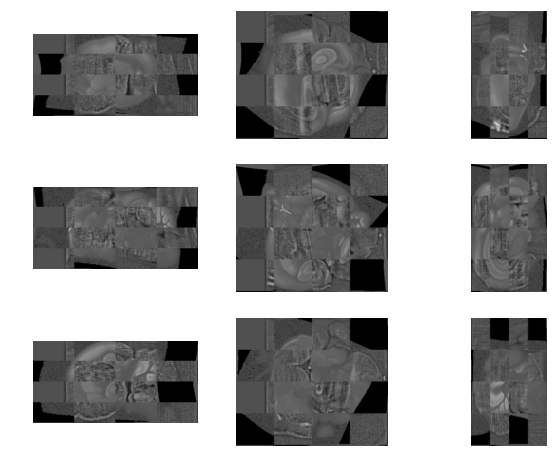

In [70]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm, img_bc_w))

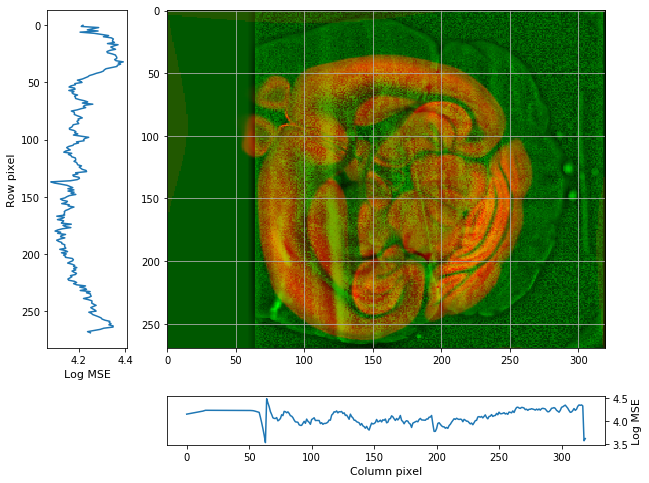

In [71]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[:,50,:], color_blend=True)

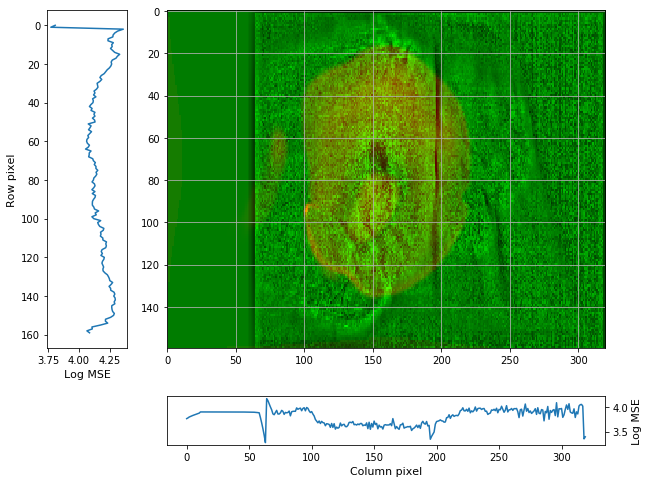

In [72]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[50,:,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[50,:,:], color_blend=True)


In [73]:
sitk.WriteImage(sitk.Normalize(atlas_lddmm), './results.img')

In [76]:
print(atlas.GetSize())

(264, 160, 228)


In [75]:
print(atlas_lddmm.GetSize())

(320, 160, 270)


In [78]:
%run -i ingest_tif_stack.py -collection=missing_data_registration \
-experiment=missing_insula_atenolol_registration_results \
-channel=no_ant_rigid_no_whiten \
-img_stack=./results.img \
-fmt=img --dtype=uint16 --config=./intern.cfg --new_channel=True



True
uploading image to boss...
uint16
(0, [0, 320], [0, 160], [0, 16])
(0, [0, 320], [0, 160], [16, 32])
(0, [0, 320], [0, 160], [32, 48])
(0, [0, 320], [0, 160], [48, 64])
(0, [0, 320], [0, 160], [64, 80])
(0, [0, 320], [0, 160], [80, 96])
(0, [0, 320], [0, 160], [96, 112])
(0, [0, 320], [0, 160], [112, 128])
(0, [0, 320], [0, 160], [128, 144])
(0, [0, 320], [0, 160], [144, 160])
(0, [0, 320], [0, 160], [160, 176])
(0, [0, 320], [0, 160], [176, 192])
(0, [0, 320], [0, 160], [192, 208])
(0, [0, 320], [0, 160], [208, 224])
(0, [0, 320], [0, 160], [224, 240])
(0, [0, 320], [0, 160], [240, 256])
(0, [0, 320], [0, 160], [256, 270])
upload done! to see upload go to this link: http://ben-dev.neurodata.io:8001/ndviz_url/missing_data_registration/missing_insula_atenolol_registration_results/no_ant_rigid_no_whiten/


# Method definitions

In [88]:
def register_rigid(atlas, img, learning_rate=1e-2, fixed_mask=None, moving_mask=None, iters=200, min_step=1e-10, shrink_factors=[1], sigmas=[.150], use_mi=False, grad_tol=1e-6, verbose=False):
    """
    Performs affine registration between an atlas an an image given that they have the same spacing.
    """
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
#     registration_method.SetMetricAsMeanSquares()
    if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
    else: registration_method.SetMetricAsMeanSquares()
    # registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkBSpline)

    # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
                                                                 minStep=min_step,
    #                                                              estimateLearningRate=registration_method.EachIteration,
                                                                 gradientMagnitudeTolerance=grad_tol,
                                                                 numberOfIterations=iters)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # set the mask
    if moving_mask: 
        registration_method.SetMetricMovingMask(moving_mask)
    if fixed_mask:
        registration_method.SetMetricFixedMask(fixed_mask)

    # initial transform
    # Versor 3d rigid
    initial_transform = sitk.VersorRigid3DTransform()
    length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
    initial_transform.SetCenter(length/2.0)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform)
    # Connect all of the observers so that we can perform plotting during registration.
    if verbose:
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


    final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
                                                  sitk.Cast(atlas, sitk.sitkFloat32))
    return final_transform

In [30]:
def register_lddmm(affine_img, target_img, alpha_list=0.05, scale_list=[0.0625, 0.125, 0.25, 0.5, 1.0], 
                   epsilon_list=1e-4, min_epsilon_list=1e-10, sigma=0.1, use_mi=False, iterations=200, inMask=None,
                   refMask=None, verbose=True, out_dir=''):
    if sigma == None:
        sigma = (0.1/target_img.GetNumberOfPixels())

    (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img,
                                                                                                alphaList=alpha_list,
                                                                                                scaleList=scale_list,
                                                                                                epsilonList=epsilon_list,
                                                                                                minEpsilonList=min_epsilon_list,
                                                                                                sigma=sigma,
                                                                                                useMI=use_mi,
                                                                                                inMask=inMask,
                                                                                                refMask=refMask,
                                                                                                iterations=iterations, 
                                                                                                verbose=verbose,
                                                                                                outDirPath=out_dir)

    source_lddmm = ndreg.imgApplyField(affine_img, field, 
                                            size=target_img.GetSize(), 
                                            spacing=target_img.GetSpacing())
    return source_lddmm, field, invField

In [66]:
import sys, random, ndreg
import numpy as np
import SimpleITK as sitk
import skimage
from ndreg import preprocessor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
def plot_mse(img1, img2, blend=0.2, color_blend=False):
    height, width = img1.shape
    overlap = np.zeros((height, width)) if not color_blend else np.zeros((height, width, 3))
    if not color_blend:
        for i in range(height):
            for j in range(width):
                grey = img1[i,j]*blend + img2[i,j]*blend
                overlap[i,j] = grey
    else:
        img1 = img1 + abs(np.amin(img1))
        img2 = img2 + abs(np.amin(img2))
        img1_max = np.amax(img1)
        img2_max = np.amax(img2)
        for i in range(height):
            for j in range(width):
#                 overlap[i,j,:] = (int(img1[i,j]/img1_max * 255), int(img2[i,j]/img2_max * 255), 0)
                overlap[i,j,:] = (img1[i,j]/img1_max, img2[i,j]/img2_max, 0)

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))

    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)

In [87]:
import ndreg
import csv
import numpy as np
import SimpleITK as sitk
import skimage
import matplotlib
from matplotlib import pyplot as plt


def resample(image, transform, ref_img, default_value=0.0):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = ref_img
    interpolator = sitk.sitkBSpline
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)


# Utility functions for plotting

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r)
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r)
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_slices_with_alpha(fixed, moving, alpha, vmax):
    img = (1.0 - alpha)*fixed + alpha*moving
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r, vmax=vmax)
    plt.axis('off')
    plt.show()

def display_images_with_alpha(slice_num, alpha, fixed, moving, axis=2, vmax=1000):
    if axis == 0: display_slices_with_alpha(fixed[slice_num,:,:], moving[slice_num,:,:], alpha, vmax)
    elif axis == 1: display_slices_with_alpha(fixed[:,slice_num,:], moving[:,slice_num,:], alpha, vmax)
    else: display_slices_with_alpha(fixed[:,:,slice_num], moving[:,:,slice_num], alpha, vmax)
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))  
    
